# **Modeling Inflammatory Bowel Disease Progression with Group Lasso for logistic regression**
==================================

# I. Data Preparation
To prepare data for Group-Lasso logistic regression modeling of Inflammatory Bowel Disease (IBD) flares based on MyIBDcoach variables, follow these steps:

1. **Define Variable Groups**: Identify and categorize variables into groups such as baseline characteristics, psychosocial factors, lifestyle choices, medication usage, and tool usage.

2. **Import Data**: Load the necessary datasets from Excel files using `read_excel()`, ensuring to define column names.

3. **Prepare BaseLine Data**: Extract baseline-related information.

4. **Prepare Medication Data**: Extract medication-related information, creating a binary indicator for whether each user is taking specific medications, and Reshape Medication Data into the correct format, using `pivot_wider()`, allowing each medication to become a separate column with binary indicators.

5.  **Prepare psychosocial Data**:  Extract psychosocial-related information,

6.  **Prepare lifestyle Data**:  Extract lifestyle-related information,

7.  **Prepare tool usage Data**:  Extract tool-usage-related information,

8.  **Prepare Flare Data**: Extract the dependent variable.

9.  **Join all Datasets**: Merge all main datasets based on the `UserName` variable to create a comprehensive dataset that includes all relevant predictors for modeling IBD flare.

This structured approach ensures that all necessary variables are included and properly formatted for effective analysis using Group-Lasso logistic regression, facilitating insights into factors influencing IBD flare events.

In [99]:
# Load Required Libraries
# -----------------------
library(knitr)
library(labelled)     # For handling variable labels
knitr::opts_chunk$set(erro= F, warning= F, message=F, fig.width = 8, collapse = TRUE)
library(readxl) # import xlsx data
library(gglasso) # load gglasso library
library(tidyverse)
library(pROC)

### Import Data

In [100]:
# Import data from Excel file
## 1. Import baseline & psychosocial data
### Define your desired column names
desired_col_names <- c('UserName','IBDZL','Center','NumberOfMeasurements',
                       'NumberOfMeasurementsWithCalproWithinRange',
                       'NumberofMeasurementsMeetingCalpro<150Pain>2','PercCriteria1',
                       'PercCriteria2',
                       'NumberofMeasurementsMeetingCalpro<150Pain<3','PercCriteria',
                       'GroupsCalpro<150Pain>2','GroupNewReversed','Gender','DateofBirth',
                       'AgeAtCohortEntry','DiseaseEntity','DiagDateFinal','AgeatDiag',
                       'DiseaseDurationAtCohortEntry','DiseaseDurationCategory','Montreal_A_diag',
                       'Montreal_L_diag_final','Montreal_B_diag_final','Montreal_P_diag_final',
                       'Montreal_P_ever_manualfinal','Montreal_U_diag_final','Montreal_U_ever_final',
                       'Montreal_E_diag_Final','Montreal_E_ever_final',
                       'IBDsurgeryHistory_manualfinal','IBDsurgery_resection_manualfinal',
                       'CCI_adjusted','BMI_baseline','BMI_category',
                       'CurrentStoma','Stoma_history','Smoking_final','Family_IBD_final',
                       'MIAH_pain_median','MIAH_pain_firstvalue','MIAH_pain_mean',
                       'Stress_median','Stress_firstvalue','Stress_mean',
                       'Depression_median_1','Depression_firstvalue_1','Depression_mean_1',
                       'Depression_median_2','Depression_firstvalue_2','Depression_mean_2',
                       'Anxious_median_1','Anxious_firstvalue_1','Anxious_mean_1',
                       'Anxious_median_2','Anxious_firstvalue_2','Anxious_mean_2',
                       'Fatigue_median_1','Fatigue_firstvalue_1','Fatigue_mean_1',
                       'Fatigue_median_2','Fatigue_firstvalue_2','Fatigue_mean_2',
                       'LifeEvents_incase')

## 1. Import data using the defined col names
data <- read_excel("/kaggle/input/database/data.xlsx", sheet = 1,col_names = desired_col_names,skip = 1)#Baseline

## 2. Import Medication Data
dataMed <- read_excel("/kaggle/input/database/PRIQ_Masterfile_Medication_MUMCZDL_0812proj.xlsx", sheet = 1)#Medication

## 3. Import lifestyle Data
dataLifeStyle <- read_excel("/kaggle/input/database/Physical Exercise.xlsx", sheet = 1)#lifestyle

print(paste0('Data source import complete'))

[1] "Data source import complete"


In [101]:
table(data$GroupNewReversed)


  0   1 
231 198 

## I.2 Prepare BaseLine &  psychosocial data

Let's start with the baseline data, here are the explanatory variables in the Baseline:





| Label                                   | Variable Name                                         | Measurement Scale | # of Levels | Categories                               |
|-----------------------------------------|------------------------------------------------------|-------------------|-------------|------------------------------------------|
| Gender                                  | Gender                                               | Nominal           | 2           | Female, Male                             |
| AgeAtCohortEntry                       | Age at baseline (years)                             | Interval          |             |                                          |
| DiseaseEntity                           | Phenotype                                           | Nominal           | 2           | CD, UC                                   |
| DiseaseDurationAtCohortEntry           | Disease duration                                    | Interval          |             |                                          |
| DiseaseDurationCategory                 | Disease duration                                    | Nominal           | 2           |                                          |
| AgeatDiag                               | Age at diagnosis                                    | Ratio             |             |                                          |
| Montreal_A_diag                         | Montreal at diagnosis: Age                          | Nominal           | 3           | <16, 16-40, >40                          |
| Montreal_L_Diag                         | Montreal at diagnosis: Disease location (CD)       | Nominal           | 3           | ileal, colonic, ileocolonic             |
| Montreal_B_Diag                         | Montreal at diagnosis: Disease behavior (CD)       | Nominal           | 3           | inflammatory, stricturing, penetrating   |
| Montreal_P_diag_final                   | Montreal at diagnosis: Perianal disease (CD)      | Nominal           | 3           | ileal, colonic, ileocolonic             |
| Montreal_U_diag_final                   | Montreal at diagnosis: Upper GI disease (CD)      | Nominal           | 2           | No, Yes                                  |
| Montreal_E_diag_Final                   | Montreal at diagnosis: Disease extent (UC)         | Nominal           | 3           | proctitis, left-sided colitis, extensive/pancolitis |
| Montreal_P_ever_manualfinal             | Montreal: Perianal disease maximum (CD)            | Nominal           | 2           | No, Yes                                  |
| Montreal_U_ever_final                   | Montreal: Upper GI disease maximum (CD)            | Nominal           | 2           | No, Yes                                  |
| Montreal_E_ever_final                   | Montreal: Disease extent UC maximum                 | Nominal           | 3           | proctitis, left-sided colitis, extensive/pancolitis |
| IBDsurgeryHistory_manualfinal            | History of IBD surgery                              | Nominal           | 2           | No, Yes                                  |
| IBDsurgery_resection_manualfinal        | IBD surgery resection                               | Nominal           | 2           | No, Yes                                  |
| Family_IBD_final                        | Family history IB                                   | Nominal           | 2           | No, Yes                                  |
| Smoking_final                           | Current smoking at baseline                         | Nominal           | 2           | No, Yes                                  |
| CurrentStoma                           | Current stoma at baseline                           | Nominal           | 2           | No, Yes                                  |
| Stoma_history                          | History of stoma at baseline                        | Nominal           | 2           | No, Yes                                  |
| BMI_baseline                           | BMI at baseline                                     | Ratio             |             |                                          |
| BMI_category                           | BMI category at baseline                            | Nominal           | 3           | 18.5-25.0, 25.0-30.0, ≥30.0            |
| CCI_adjusted                           |- Adjusted rate ratios for Crohn’s disease-related surgery. CCI   |- Nominal      |- 3         |- 0, 1-2, >2                              |

Medication at baseline 

In [102]:
data$MIAH_pain <-  data$MIAH_pain_mean  #data$MIAH_pain_median + data$MIAH_pain_firstvalue +
data$Stress <- data$Stress_mean # data$Stress_median + data$Stress_firstvalue + 
data$Depression1 <- data$Depression_mean_1 # data$Depression_median_1 + data$Depression_firstvalue_1 + 
data$Depression2 <- data$Depression_mean_2 # data$Depression_median_2 + data$Depression_firstvalue_2 + 
data$Anxious1 <- data$Anxious_mean_1# data$Anxious_median_1 + data$Anxious_firstvalue_1 + 
data$Anxious2 <- data$Anxious_mean_2 # data$Anxious_median_2 + data$Anxious_firstvalue_2 + 
data$Fatigue1 <- data$Fatigue_mean_1 # data$Fatigue_median_1 + data$Fatigue_firstvalue_1 + 
data$Fatigue2 <- data$Fatigue_mean_2 # data$Fatigue_median_2 + data$Fatigue_firstvalue_2 + 

In [103]:
data <- data %>%
  select(-c(2:11, 39:62,DateofBirth,DiagDateFinal))  # Drop first 11 variables: 'IBDZL''Center''NumberOfMeasurements''NumberOfMeasurementsWithCalproWithinRange''NumberofMeasurementsMeetingCalpro<150Pain>2''PercCriteria...7''PercCriteria...8''NumberofMeasurementsMeetingCalpro<150Pain<3''PercCriteria...10''GroupsCalpro<150Pain>2'

In [104]:
# Preparing data 
# Convert response variables to factor  
data$GroupNewReversed <- factor(data$GroupNewReversed, labels= c("no flares", "flares"))
data$Gender <- factor(data$Gender, labels= c("Female", "Male"))  
data$DiseaseEntity <- factor(data$DiseaseEntity, labels= c("CD", "UC"))
data$DiseaseDurationCategory <- factor(data$DiseaseDurationCategory)#, labels= 3 cats c())
data$IBDsurgeryHistory_manualfinal <- factor(data$IBDsurgeryHistory_manualfinal, labels= c("No", "Yes"))
data$IBDsurgery_resection_manualfinal <- factor(data$IBDsurgery_resection_manualfinal, labels= c("No", "Yes"))
data$CCI_adjusted <- factor(data$CCI_adjusted, labels= c("0", "1-2", ">2"))
data$BMI_category <- factor(data$BMI_category, labels= c("18.5-25.0", "25.0-30.0","≥30.0"))
data$CurrentStoma <- factor(data$CurrentStoma, labels= c("No", "Yes"))
data$Stoma_history <- factor(data$Stoma_history, labels= c("No", "Yes"))
data$Family_IBD_final <- factor(data$Family_IBD_final)#, labels=3 cats c())
data$Montreal_A_diag <- factor(data$Montreal_A_diag, labels= c("<16", "16-40",">40"))
data$Montreal_L_diag_final   <- factor(data$Montreal_L_diag_final, labels= c("ileal","colonic","ileocolonic","NA"))# "upper GI"
data$Montreal_B_diag_final  <- factor(data$Montreal_B_diag_final, labels= c("inflammatory","stricturing", "penetrating","NA"))
data$Montreal_P_diag_final   <- factor(data$Montreal_P_diag_final, labels= c("No", "Yes","NA"))
data$Montreal_P_ever_manualfinal  <- factor(data$Montreal_P_ever_manualfinal, labels= c("No", "Yes","NA"))
data$Montreal_U_diag_final  <- factor(data$Montreal_U_diag_final, labels= c("No", "Yes","NA"))
data$Montreal_U_ever_final  <- factor(data$Montreal_U_ever_final, labels= c("No", "Yes","NA"))
data$Montreal_E_diag_Final <- factor(data$Montreal_E_diag_Final, labels= c("proctitis", "left-sided colitis","extensive/pancolitis","NA"))
data$Montreal_E_ever_final <- factor(data$Montreal_E_ever_final, labels= c("proctitis", "left-sided colitis","extensive/pancolitis","NA"))

## I.3 Prepare Medicament data

In [105]:
dataMed <- dataMed %>% select(c(Username, Medicament))
dataMed$value <-  1  # Create a column with 1s indicating medication taken

# reshaping the data : Transform the data from long to wide format
wide_dataMed <- dataMed %>%
  pivot_wider(names_from = Medicament,
              values_from = value, values_fill = list(value = 0),
              values_fn = list(value = sum))%>%
  rename(UserName = Username)          # Rename the variable



# Convert MEDICATION columns to factors with labels No, Yes, and NA
wide_dataMed[c(-1)] <- wide_dataMed[c(-1)] %>%
  mutate(across(everything(), 
                 ~ factor(.,
                          levels= c(0,1, "NA"),  # Add "NA" as a level
                           labels = c("No", "Yes", "NA" ) ,
                         exclude = NULL)))  # Include NA as a level
wide_dataMed <- wide_dataMed %>%
  select(UserName,Adalimumab, `Budesonide`, `Geen medicatie`, Infliximab, 
         Mercaptopurine, Mesalazine, Prednison, Tioguanine,
         Ustekinumab, Vedolizumab)

## I.4 Prepare lifestyle Data

In [106]:
# Smoking Status
data$Smoking_final <- factor(data$Smoking_final, labels= c("Never", "Current","Former"))

# Reorder variables in dataLifeStyle, moving Smoking_final to the end
data <- data %>%
  select(-Smoking_final, everything(), Smoking_final)

# Life Events
data$LifeEvents_inCase  <- factor(data$LifeEvents_incase, labels= c("No", "Yes"))
data$LifeEvents_incase  <- NULL

# Physical Exercise
## Recode 'Physical Exercise' to factor with two levels
data$PhysicalExercise <- recode(dataLifeStyle$`Physical Exercise`,
                                            `0` = "none",   # 0 becomes "none"
                                            `1` = "none",  # 1 becomes "none"
                                            `2` = "none",  # 2 becomes "none"
                                            `3` = "none",  # 3 becomes "none"
                                            `4` = "none",  # 4 becomes "none"
                                            `5` = "very active")  # 5 becomes "very active"

## Convert to factor
data$PhysicalExercise <- as.factor(data$PhysicalExercise)



### I.5 Join-Datasets based on UserName

In [107]:
joined_data <- data %>%
  left_join(wide_dataMed, by = "UserName") %>% # Use inner_join to combine by UserName
    rename(Flares= GroupNewReversed)%>%
    mutate(Flares = recode(Flares,  "no flares"="No", "flares"="Yes")) 
#joined_data <- na.omit(joined_data)

In [108]:
# Set variable labels
joined_data <- joined_data %>%
  set_variable_labels(
     Flares=  "Flares",
    BMI_category   = "BMI at baseline",        
CCI_adjusted =       	"CCI Adjusted",
CurrentStoma  =   "Current stoma at baseline",
DiseaseDurationCategory  =   "Disease duration",
DiseaseEntity  =   "Phenotype",
Family_IBD_final  =   "Family history IB",
Gender  =   "Gender",
IBDsurgeryHistory_manualfinal =   "History of IBD surgery",
IBDsurgery_resection_manualfinal =   "IBD surgery resection",
Montreal_A_diag =   "Montreal at diagnosis: Age",
Montreal_B_diag_final  =   "Montreal at diagnosis: Disease behavior (CD)",
Montreal_E_diag_Final  =    	"Montreal at diagnosis: Disease extent (UC)",
Montreal_E_ever_final   =   "Montreal: Disease extent UC maximum",
Montreal_L_diag_final   =  "Montreal at diagnosis: Disease location (CD)", 
Montreal_P_diag_final =   "Montreal at diagnosis: Perianal disease (CD)",
Montreal_P_ever_manualfinal  = "Montreal: Perianal disease maximum (CD)"  ,
Montreal_U_diag_final  =   "Montreal at diagnosis:Upper GI disease (CD)",
Montreal_U_ever_final  =   "Montreal: Upper GI disease maximum (CD)",
Stoma_history   =   "History of stoma",
      AgeAtCohortEntry = "Age at baseline",
      AgeatDiag = "Age at diagnosis",
      DiseaseDurationAtCohortEntry = "Disease duration at baseline",
      BMI_baseline = "BMI at baseline",
      LifeEvents_inCase = "Life Events",
      Smoking_final  =   "Current smoking at baseline",
    PhysicalExercise = "Physical Exercise"
  )


#  II. Statistics


### II.1 DV Statistics

The output table indicates that among the participants, 225 (52.4%) experienced no flares, while 204 (**47.6%**) **reported experiencing flares**.

In [109]:
# Compute frequency and percentage of GroupNewReversed
group_summary <- joined_data %>%
  group_by(Flares) %>%
  summarise(Frequency = n(),
            Percentage = (n() / nrow(joined_data)) * 100) %>%
  ungroup()

# Format the table as a Markdown table
markdown_table <- group_summary %>%
  mutate(Percentage = round(Percentage, 1)) %>%  # Round percentage to one decimal place
  rename(
         `Frequency (N)` = Frequency,
         `Percentage (%)` = Percentage) %>%
  kable(format = "markdown", align = "c")

# Display the Markdown table
markdown_table




| Flares | Frequency (N) | Percentage (%) |
|:------:|:-------------:|:--------------:|
|   No   |      231      |      53.8      |
|  Yes   |      198      |      46.2      |


## II.1 Baseline Statistics

Baseline: columns 2 to 26

In [110]:
# Select only qualitative variables (character or factor types)
qualitative_data <- joined_data[c(2:25)] %>% 
  select(where(is.factor))


# Define a mapping of variable names to labels

         label_mapping <- c(
BMI_category   = "BMI at baseline",        
CCI_adjusted =       	"CCI Adjusted ",
CurrentStoma  =   "Current stoma at baseline",
DiseaseDurationCategory  =   "Disease duration",
DiseaseEntity  =   "Phenotype",
Family_IBD_final  =   "Family history IB",
Gender  =   "Gender",
IBDsurgeryHistory_manualfinal =   "History of IBD surgery",
IBDsurgery_resection_manualfinal =   "IBD surgery resection",
Montreal_A_diag =   "Montreal at diagnosis: Age",
Montreal_B_diag_final  =   "Montreal at diagnosis: Disease behavior (CD)",
Montreal_E_diag_Final  =    	"Montreal at diagnosis: Disease extent (UC)",
Montreal_E_ever_final   =   "Montreal: Disease extent UC maximum",
Montreal_L_diag_final   =  "Montreal at diagnosis: Disease location (CD)", 
Montreal_P_diag_final =   "Montreal at diagnosis: Perianal disease (CD)",
Montreal_P_ever_manualfinal  = "Montreal: Perianal disease maximum (CD)"  ,
Montreal_U_diag_final  =   "Montreal at diagnosis:Upper GI disease (CD)",
Montreal_U_ever_final  =   "Montreal: Upper GI disease maximum (CD)",
Stoma_history   =   "History of stoma"
)


# Compute cross frequency and percentage for each explanatory factor
cross_freq <- qualitative_data %>%
  pivot_longer(-Flares, names_to = "Factor", values_to = "Value") %>%
  group_by(Factor, Flares, Value) %>%
  summarise(Freq = n(), .groups = "drop") %>%
  group_by(Factor, Value) %>%
  mutate(Pct = round((Freq / sum(Freq) * 100)),2)  # Calculate percentage


# Automatically gather unique categories from the data
apa_table <- cross_freq %>%
  select(Factor, Value,Flares,  Freq, Pct) %>%
  rename( Category = Value) %>%
  arrange(Factor , Category, Flares)


# Print the final sorted table with p-values
print(kable(apa_table, format = "markdown", align = "c"))



|              Factor              |       Category       | Flares | Freq | Pct |
|:--------------------------------:|:--------------------:|:------:|:----:|:---:|
|           BMI_category           |      18.5-25.0       |   No   |  4   | 67  |
|           BMI_category           |      18.5-25.0       |  Yes   |  2   | 33  |
|           BMI_category           |      25.0-30.0       |   No   | 109  | 60  |
|           BMI_category           |      25.0-30.0       |  Yes   |  74  | 40  |
|           BMI_category           |        ≥30.0         |   No   | 118  | 49  |
|           BMI_category           |        ≥30.0         |  Yes   | 122  | 51  |
|           CCI_adjusted           |          0           |   No   |  95  | 52  |
|           CCI_adjusted           |          0           |  Yes   |  89  | 48  |
|           CCI_adjusted           |         1-2          |   No   |  94  | 55  |
|           CCI_adjusted           |         1-2          |  Yes   |  78  | 45  |
|           CC

### **Compute p-values**

In [111]:
# Create a function to calculate p-values for categorical variables
calculate_pvalue <- function(data, variable) {
  # Create a contingency table
  cont_table <- table(data[[variable]], data$Flares)
  
  # Perform chi-square test (or Fisher's exact test if sample size is small)
  if (any(chisq.test(cont_table)$expected < 5)) {
    test_result <- fisher.test(cont_table, simulate.p = TRUE, B = 10000)
  } else {
    test_result <- chisq.test(cont_table)
  }
  
  return(round(test_result$p.value,5))
}

# Apply the function to each variable
variable_names <- names(qualitative_data)[names(qualitative_data) != "Flares"]

# Using sapply with a function that passes both arguments
p_values <- sapply(variable_names, function(var) calculate_pvalue(qualitative_data, var))

# Create a data frame with variable names and p-values
p_value_df <- data.frame(
  Factor = variable_names,
  p_value = p_values)%>%
        arrange((p_value))
                   
pvalues_df <- p_value_df%>%
        mutate(Factor = recode(Factor, !!!label_mapping))

pvalues_df
 

Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”


,Factor,p_value
,<chr>,<dbl>
Gender,Gender,0.00000
DiseaseDurationCategory,Disease duration,0.00087
Montreal_L_diag_final,Montreal at diagnosis: Disease location (CD),0.02831
BMI_category,BMI at baseline,0.07929
DiseaseEntity,Phenotype,0.09330
Montreal_E_diag_Final,Montreal at diagnosis: Disease extent (UC),0.09878
Montreal_P_ever_manualfinal,Montreal: Perianal disease maximum (CD),0.14332
Montreal_U_diag_final,Montreal at diagnosis:Upper GI disease (CD),0.17492
Montreal_U_ever_final,Montreal: Upper GI disease maximum (CD),0.17577


In [112]:

#  Add p-values to the table
final_apa_table_with_pvalues <- apa_table %>%
  left_join(p_value_df %>% select(Factor, p_value), by = "Factor") %>%
  arrange(Factor, Category, Flares)

# Sort by p-values
# get the ordered list of variables from p_value_df
ordered_Factors <- factor(p_value_df$Factor, 
                           levels = p_value_df$Factor)

# Create a factor with levels in the desired order for sorting
final_apa_table_with_pvalues$Factor <- factor(final_apa_table_with_pvalues$Factor,
                             levels = levels(ordered_Factors))

# Sort the apa_table based on this p-values
final_apa_table_with_pvalues <- final_apa_table_with_pvalues %>%
  arrange(Factor)%>%
        mutate(Factor = recode(Factor, !!!label_mapping))

# Print the final sorted table with p-values
print(kable(final_apa_table_with_pvalues, format = "markdown", align = "c"))



|                    Factor                    |       Category       | Flares | Freq | Pct | p_value |
|:--------------------------------------------:|:--------------------:|:------:|:----:|:---:|:-------:|
|                    Gender                    |        Female        |   No   | 125  | 69  | 0.00000 |
|                    Gender                    |        Female        |  Yes   |  57  | 31  | 0.00000 |
|                    Gender                    |         Male         |   No   | 106  | 43  | 0.00000 |
|                    Gender                    |         Male         |  Yes   | 141  | 57  | 0.00000 |
|               Disease duration               |          0           |   No   |  97  | 46  | 0.00087 |
|               Disease duration               |          0           |  Yes   | 116  | 54  | 0.00087 |
|               Disease duration               |          1           |   No   | 134  | 62  | 0.00087 |
|               Disease duration               |          1   

In [113]:
# Select quantitative variables from joined_data
quantitative_data <- joined_data[c(2:25)] %>%
  select(where(is.numeric), Flares) # Keep only numeric columns and GroupNewReversed

# Calculate t-test p-values for all quantitative variables
calculate_ttest_pvalue <- function(data, variable) {
  # Split the data into two groups based on Flares
  group1 <- data[data$Flares == levels(data$Flares)[1], variable]
  group2 <- data[data$Flares == levels(data$Flares)[2], variable]
  
  # Check if there's enough data in both groups
  if (length(group1) > 0 && length(group2) > 0) {
    # Perform t-test
    test_result <- t.test(group1, group2)
    return(round(test_result$p.value, 5))
  } else {
    return(NA)
  }
}

                   
# Compute mean and standard deviation for each quantitative variable by flare status
summary_stats <- quantitative_data %>%
  group_by(Flares) %>%
  summarise(across(where(is.numeric), 
                   ~ paste0(round(mean(., na.rm = TRUE), 2), " (", round(sd(., na.rm = TRUE), 2), ")"),
                   .names = "{.col}")) %>%
  ungroup()

# Calculate p-values for each variable
continuous_variable_names <- names(quantitative_data)[names(quantitative_data) != "Flares"]
t_pvalues <- sapply(continuous_variable_names, function(var) calculate_ttest_pvalue(quantitative_data, var))
p_value_df <- data.frame(Variable = continuous_variable_names, p_value = t_pvalues)



# Add p-values as a new row

# Convert the Flares column to character first
summary_stats$Flares <- as.character(summary_stats$Flares)
p_values_row <- c("pvalues", p_value_df$p_value)
names(p_values_row) <- c("Flares", continuous_variable_names)
apa_table <- rbind(summary_stats, p_values_row)


# Format the summary statistics for APA style
# Replace R variable names with labels in the table
for (var in names(apa_table)[-1]) {  # Exclude 'Flares'
  label <- var_label(joined_data[[var]])  # Get label for the variable
  new_name <- paste(label, "(Mean, SD)", sep = " ")
  colnames(apa_table)[colnames(apa_table) == var] <- new_name
}

## Transpose the table
apa_table_transposed <- as.data.frame(t(apa_table))
# Set the first row as column names
colnames(apa_table_transposed) <- apa_table_transposed[1, ]
apa_table_transposed <- apa_table_transposed[-1, ]


apa_table_transposed <- apa_table_transposed %>%
                    arrange(pvalues)

# Print the transposed APA-style table
print(kable(apa_table_transposed, format = "markdown", align = "c"))



|                                        |      No       |      Yes      | pvalues |
|:---------------------------------------|:-------------:|:-------------:|:-------:|
|Disease duration at baseline (Mean, SD) | 14.06 (11.03) | 11.49 (10.41) | 0.01347 |
|Age at baseline (Mean, SD)              | 50.53 (14.59) | 47.12 (13.97) | 0.01415 |
|BMI at baseline (Mean, SD)              | 25.79 (3.91)  | 26.71 (4.73)  | 0.0306  |
|Age at diagnosis (Mean, SD)             | 36.47 (14.47) | 35.65 (13.7)  | 0.54346 |


## II.3 psychosocial Statistics

In [114]:
# Select quantitative variables from joined_data
quantitative_data <- joined_data[c(2,26:33)] %>%
  select(where(is.numeric), Flares) # Keep only numeric columns and GroupNewReversed


                   
# Compute mean and standard deviation for each quantitative variable by flare status
summary_stats <- quantitative_data %>%
  group_by(Flares) %>%
  summarise(across(where(is.numeric), 
                   ~ paste0(round(mean(., na.rm = TRUE), 2), " (", round(sd(., na.rm = TRUE), 2), ")"),
                   .names = "{.col}")) %>%
  ungroup()

# Calculate p-values for each variable
continuous_variable_names <- names(quantitative_data)[names(quantitative_data) != "Flares"]
t_pvalues <- sapply(continuous_variable_names, function(var) calculate_ttest_pvalue(quantitative_data, var))
p_value_df <- data.frame(Variable = continuous_variable_names, p_value = t_pvalues)



# Add p-values as a new row

# Convert the Flares column to character first
summary_stats$Flares <- as.character(summary_stats$Flares)
p_values_row <- c("pvalues", p_value_df$p_value)
names(p_values_row) <- c("Flares", continuous_variable_names)
apa_table <- rbind(summary_stats, p_values_row)

                    
# Format the summary statistics for APA style
# Replace R variable names with labels in the table
for (var in names(apa_table)[-1]) {  # Exclude 'Flares'
  new_name <- paste(var, "(Mean, SD)", sep = " ")
  colnames(apa_table)[colnames(apa_table) == var] <- new_name
}

## Transpose the table
apa_table_transposed <- as.data.frame(t(apa_table))
# Set the first row as column names
colnames(apa_table_transposed) <- apa_table_transposed[1, ]
apa_table_transposed <- apa_table_transposed[-1, ]


apa_table_transposed <- apa_table_transposed %>%
                    arrange(pvalues)

# Print the transposed APA-style table
print(kable(apa_table_transposed, format = "markdown", align = "c"))



|                       |     No      |     Yes     | pvalues |
|:----------------------|:-----------:|:-----------:|:-------:|
|MIAH_pain (Mean, SD)   |  0.8 (0.9)  |  4 (1.51)   |    0    |
|Stress (Mean, SD)      | 3.46 (1.77) | 4.64 (1.77) |    0    |
|Depression1 (Mean, SD) | 1.45 (0.65) | 1.91 (0.76) |    0    |
|Anxious1 (Mean, SD)    | 1.2 (0.46)  | 1.49 (0.66) |    0    |
|Fatigue1 (Mean, SD)    | 4.11 (2.19) | 6.28 (1.89) |    0    |
|Fatigue2 (Mean, SD)    | 0.68 (0.47) | 0.94 (0.23) |    0    |
|Anxious2 (Mean, SD)    |  0.1 (0.3)  | 0.23 (0.42) | 0.00041 |
|Depression2 (Mean, SD) | 0.04 (0.2)  | 0.14 (0.35) | 0.00058 |


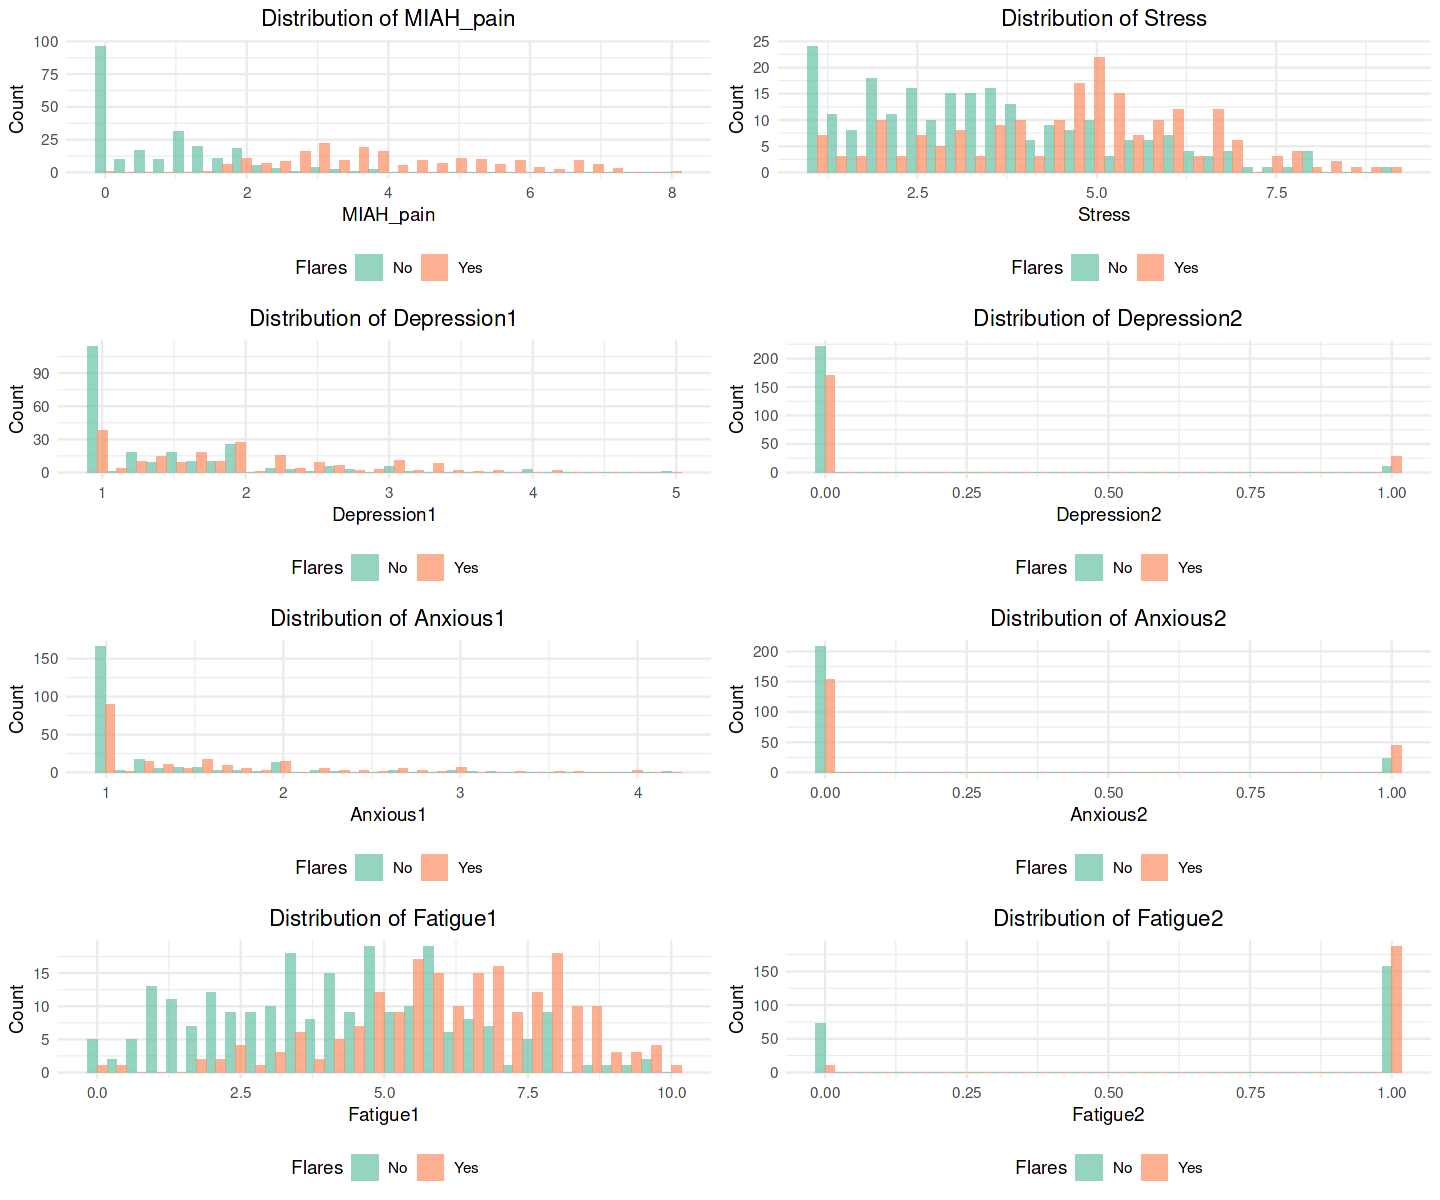

In [115]:
# Load required libraries
library(purrr)
library(gridExtra)

# Get list of numeric columns (excluding GroupNewReversed)
numeric_cols <- names(quantitative_data)[sapply(quantitative_data, is.numeric)]
numeric_cols <- numeric_cols[numeric_cols != "Flares"]

# Function to create histogram for each variable
create_histogram <- function(data, var) {
  ggplot(data, aes(x = .data[[var]], fill = Flares)) +
    geom_histogram(position = "dodge", bins = 30, alpha = 0.7) +
    theme_minimal() +
    labs(title = paste("Distribution of", var),
         x = var,
         y = "Count") +
    theme(legend.position = "bottom",
          plot.title = element_text(hjust = 0.5)) +
    scale_fill_brewer(palette = "Set2")
}

# Create list of plots
plots <- map(numeric_cols, ~create_histogram(quantitative_data, .x))

# Arrange plots in a grid
# Calculate number of rows and columns for grid
n_plots <- length(plots)
n_cols <- min(2, n_plots)
n_rows <- ceiling(n_plots / n_cols)

# Set default figure size
options(repr.plot.width=12, repr.plot.height=10)
# Create grid of plots
grid.arrange(grobs = plots, ncol = n_cols, nrow = n_rows)





## II.2 lifestyle Statistics

In [116]:
# Select only qualitative variables (character or factor types)
qualitative_data <- joined_data[c(2,34:36)] %>% 
  select(where(is.factor))

# Define a mapping of variable names to labels
label_mapping <- c(
    LifeEvents_incase = "Life Events",
    Smoking_final  =   "Current smoking at baseline",
    PhysicalExercise = "Physical Exercise"
)

# Compute cross frequency and percentage for each explanatory factor
cross_freq <- qualitative_data %>%
  pivot_longer(-Flares, names_to = "Factor", values_to = "Value") %>%
  group_by(Factor, Flares, Value) %>%
  summarise(Freq = n(), .groups = "drop") %>%
  group_by(Factor, Value) %>%
  mutate(Pct = round((Freq / sum(Freq) * 100)),2)  # Calculate percentage


# Automatically gather unique categories from the data
apa_table <- cross_freq %>%
  select(Factor, Value,Flares,  Freq, Pct) %>%
  rename( Category = Value) %>%
  arrange(Factor , Category, Flares)


# Print the APA-style table
print(kable(apa_table, format = "markdown", align = "c"))



|      Factor       |  Category   | Flares | Freq | Pct |
|:-----------------:|:-----------:|:------:|:----:|:---:|
| LifeEvents_inCase |     No      |   No   | 102  | 68  |
| LifeEvents_inCase |     No      |  Yes   |  48  | 32  |
| LifeEvents_inCase |     Yes     |   No   | 129  | 46  |
| LifeEvents_inCase |     Yes     |  Yes   | 150  | 54  |
| PhysicalExercise  |    none     |   No   | 166  | 55  |
| PhysicalExercise  |    none     |  Yes   | 135  | 45  |
| PhysicalExercise  | very active |   No   |  65  | 51  |
| PhysicalExercise  | very active |  Yes   |  63  | 49  |
|   Smoking_final   |    Never    |   No   |  98  | 52  |
|   Smoking_final   |    Never    |  Yes   |  90  | 48  |
|   Smoking_final   |   Current   |   No   |  15  | 54  |
|   Smoking_final   |   Current   |  Yes   |  13  | 46  |
|   Smoking_final   |   Former    |   No   | 118  | 55  |
|   Smoking_final   |   Former    |  Yes   |  95  | 45  |


In [117]:
# Apply the function to each variable
variable_names <- names(qualitative_data)[names(qualitative_data) != "Flares"]

# Using sapply with a function that passes both arguments
p_values <- sapply(variable_names, function(var) calculate_pvalue(qualitative_data, var))

# Create a data frame with variable names and p-values
p_value_df <- data.frame(
  Factor = variable_names,
  p_value = p_values)%>%
        arrange((p_value))
                   
pvalues_df <- p_value_df%>%
        mutate(Factor = recode(Factor, !!!label_mapping))

pvalues_df

,Factor,p_value
,<chr>,<dbl>
LifeEvents_inCase,LifeEvents_inCase,0.00003
PhysicalExercise,Physical Exercise,0.46872
Smoking_final,Current smoking at baseline,0.80616


## II.2 Medicament Statistics

In [118]:
# Select only qualitative variables (character or factor types)
qualitative_data <- joined_data[c(2, 37:46)] %>% 
  select(where(is.factor))

# Compute cross frequency and percentage for each explanatory factor
cross_freq <- qualitative_data %>%
  pivot_longer(-Flares, names_to = "Factor", values_to = "Value") %>%
  group_by(Factor, Flares, Value) %>%
  summarise(Freq = n(), .groups = "drop") %>%
  group_by(Factor, Value) %>%
  mutate(Pct = round((Freq / sum(Freq) * 100)),2)  # Calculate percentage

# Automatically gather unique categories from the data
apa_table <- cross_freq %>%
  select(Factor, Value,Flares,  Freq, Pct) %>%
  rename( Category = Value) %>%
  arrange(Factor , Category, Flares)


# Print the APA-style table
print(kable(apa_table, format = "markdown", align = "c"))



|     Factor     | Category | Flares | Freq | Pct |
|:--------------:|:--------:|:------:|:----:|:---:|
|   Adalimumab   |    No    |   No   | 168  | 54  |
|   Adalimumab   |    No    |  Yes   | 144  | 46  |
|   Adalimumab   |   Yes    |   No   |  58  | 59  |
|   Adalimumab   |   Yes    |  Yes   |  40  | 41  |
|   Adalimumab   |    NA    |   No   |  5   | 26  |
|   Adalimumab   |    NA    |  Yes   |  14  | 74  |
|   Budesonide   |    No    |   No   | 200  | 54  |
|   Budesonide   |    No    |  Yes   | 167  | 46  |
|   Budesonide   |   Yes    |   No   |  27  | 51  |
|   Budesonide   |   Yes    |  Yes   |  26  | 49  |
|   Budesonide   |    NA    |   No   |  4   | 44  |
|   Budesonide   |    NA    |  Yes   |  5   | 56  |
| Geen medicatie |    No    |   No   | 173  | 54  |
| Geen medicatie |    No    |  Yes   | 145  | 46  |
| Geen medicatie |   Yes    |   No   |  54  | 52  |
| Geen medicatie |   Yes    |  Yes   |  50  | 48  |
| Geen medicatie |    NA    |   No   |  4   | 57  |
| Geen med

In [119]:
# Apply the function to each variable
variable_names <- names(qualitative_data)[names(qualitative_data) != "Flares"]

# Using sapply with a function that passes both arguments
p_values <- sapply(variable_names, function(var) calculate_pvalue(qualitative_data, var))

# Create a data frame with variable names and p-values
p_value_df <- data.frame(
  Factor = variable_names,
  p_value = p_values)%>%
        arrange((p_value))
                   
p_value_df 

Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(cont_table):
“Chi-squared approximation may be incorrect”


,Factor,p_value
,<chr>,<dbl>
Ustekinumab,Ustekinumab,0.00110
Mesalazine,Mesalazine,0.05369
Infliximab,Infliximab,0.09429
Vedolizumab,Vedolizumab,0.13539
Prednison,Prednison,0.36056
Adalimumab,Adalimumab,0.41186
Budesonide,Budesonide,0.66283
Geen medicatie,Geen medicatie,0.73543
Mercaptopurine,Mercaptopurine,0.80952


# III. G-model

The dependent variable (DV) is `GroupNewReversed` and four groups of independent variables identified by their indices: `Baseline` ( from 3 to 25) , `psychosocial` (from 26 to 33),  `lifestyle` (from 34 to 36), `Medicament`  (from 37 to 46)

## III.1 Fit the Group Lasso Models
There are SIX models:

## Model 1: BaseLine model 

In [120]:
# Set dataset parameters
#=========================


## 1. Create data matrix for independent variables 
### one-hotmatrix
model_matrix <- model.matrix(~ . , data = joined_data[c(-1)])
#Display all column names
#column_names <- colnames(model_matrix)
#print(column_names)


## 2. Dependent variable
# ---------------------------
y <- as.numeric(model_matrix[,2])  # Convert y from factor to numeric
y <- ifelse(y == 1, -1, 1) # Convert y from {1, 2} to {-1, 1}

In [121]:
model_matrix <- as.data.frame(model_matrix) %>%
    select(-ends_with("NA")) %>%
    as.matrix()
column_names <- colnames(model_matrix)
print(column_names)

 [1] "(Intercept)"                              
 [2] "FlaresYes"                                
 [3] "GenderMale"                               
 [4] "AgeAtCohortEntry"                         
 [5] "DiseaseEntityUC"                          
 [6] "AgeatDiag"                                
 [7] "DiseaseDurationAtCohortEntry"             
 [8] "DiseaseDurationCategory1"                 
 [9] "Montreal_A_diag16-40"                     
[10] "Montreal_A_diag>40"                       
[11] "Montreal_L_diag_finalcolonic"             
[12] "Montreal_L_diag_finalileocolonic"         
[13] "Montreal_B_diag_finalstricturing"         
[14] "Montreal_B_diag_finalpenetrating"         
[15] "Montreal_P_diag_finalYes"                 
[16] "Montreal_P_ever_manualfinalYes"           
[17] "Montreal_U_diag_finalYes"                 
[18] "Montreal_U_ever_finalYes"                 
[19] "Montreal_E_diag_Finalleft-sided colitis"  
[20] "Montreal_E_diag_Finalextensive/pancolitis"
[21] "Montreal_E_eve

remove [34] "MIAH_pain" 


In [122]:
### Create data matrix for independent variables based on the final numeric matrix
x1 <- as.matrix(model_matrix[, c(3:33)])#, 34:41, 42:45, 46:55)])  # Adjust column indices as needed

## Independent variables grouped by the specified indices
# ---------------------------
group_indices1 <- c(rep(1,31)) #, rep(2, 8), rep(3, 4)) , rep(4, 10))  # Group assignments

In [123]:
# # Perform cross-validation to find the best lambda
#=========================
model1 <- cv.gglasso(x = x1, y = y, group = group_indices1, loss = "logit", nfolds = 3)

# Extract the best lambda value
best_lambda <- model1$lambda.min  # or cv_model$lambda.1se for a more regularized model

# Print the best lambda
cat("Best Lambda:", best_lambda, "\n")


Best Lambda: 0.00405655 


## Model 2: BaseLine + psychosocial model 

In [124]:
## 1. Create data matrix for independent variables 
x2 <- as.matrix(model_matrix[,  c(3:33, 35:41)])#, 42:45, 46:55)])  # Adjust column indices as needed

## 3. Independent variables grouped by the specified indices
# ---------------------------
group_indices2 <- c(rep(1,31), rep(2, 7))#, rep(3, 4)) , rep(4, 10))  # Group assignments

In [125]:
# # Perform cross-validation to find the best lambda
#=========================
model2 <- cv.gglasso(x = x2, y = y, group = group_indices2, loss = "logit", nfolds = 3)

# Extract the best lambda value
best_lambda2 <-  model2$lambda.min  

# Print the best lambda
cat("Best Lambda:", best_lambda2, "\n")

Best Lambda: 0.002148308 


##  Model 3: BaseLine + psychosocial + lifestyle model 

In [126]:
## 1. Create data matrix for independent variablse 
x3 <- as.matrix(model_matrix[,  c(3:33, 35:41, 42:45)])#, 46:55)]) # Adjust column indices as needed

## 3. Independent variables grouped by the specified indices
# ---------------------------
group_indices3 <- c(rep(1,31), rep(2, 7), rep(3, 4))# , rep(4, 10))  # Group assignments

In [127]:
# # Perform cross-validation to find the best lambda
#=========================
model3 <- cv.gglasso(x = x3, y = y, group = group_indices3, loss = "logit", nfolds = 3)

# Extract the best lambda value
best_lambda3 <- model3$lambda.min  # or cv_model$lambda.1se for a more regularized model

# Print the best lambda
cat("Best Lambda:", best_lambda3, "\n")


Best Lambda: 0.03754229 


##  Model 4: BaseLine + psychosocial + lifestyle model + Med

add 54 (Ustekinumab) in medication group

In [128]:
## 1. Create data matrix for independent variablse 
x4 <- as.matrix(model_matrix[,  c(3:33, 35:41, 42:45,54)])#, 46:55)]) # Adjust column indices as needed

## 3. Independent variables grouped by the specified indices
# ---------------------------
group_indices4 <- c(rep(1,31), rep(2, 7), rep(3, 4), rep(4, 1))# , rep(4, 10))  # Group assignments

In [129]:
# # Perform cross-validation to find the best lambda
#=========================
model4 <- cv.gglasso(x = x4, y = y, group = group_indices4, loss = "logit", nfolds = 3)

# Extract the best lambda value
best_lambda4 <- model4$lambda.min  

# Print the best lambda
cat("Best Lambda:", best_lambda4, "\n")


Best Lambda: 0.01229341 


## Model 5: Model with only Psychosocial factors 
 

In [130]:
## 1. Create data matrix for independent variables 
x5 <- as.matrix(model_matrix[, c(35:41)])  # Adjust column indices as needed

## 3. Independent variables grouped by the specified indices
# ---------------------------
group_indices5 <- c(rep(1, 7)) # Group assignments

In [131]:
# # Perform cross-validation to find the best lambda
#=========================
model5 <- cv.gglasso(x = x5, y = y, group = group_indices5, loss = "logit", nfolds = 3)
 
# Extract the best lambda value
best_lambda5 <- model5$lambda.min  

# Print the best lambda
cat("Best Lambda:", best_lambda5, "\n")

Best Lambda: 0.0006560622 


## Model 6: Model with only lifestyle factors

In [132]:
## 1. Create data matrix for independent variablse 
x6 <- as.matrix(model_matrix[,  c(42:45)])# Adjust column indices as needed

## 3. Independent variables grouped by the specified indices
# ---------------------------
group_indices6 <- c( rep(1, 4)) # Group assignments

In [133]:
# # Perform cross-validation to find the best lambda
#=========================
model6 <- cv.gglasso(x = x6, y = y, group = group_indices6, loss = "logit", nfolds = 3)

# Extract the best lambda value
best_lambda6 <- model6$lambda.min  # or cv_model$lambda.1se for a more regularized model

# Print the best lambda
cat("Best Lambda:", best_lambda6, "\n")

Best Lambda: 0.0191533 


In [134]:
# Fit the Group Lasso model using the optimal lambda
optimal_model1 <- gglasso(x = x1, y = y, group = group_indices1, loss = "logit", lambda = best_lambda)
optimal_model2 <- gglasso(x = x2, y = y, group = group_indices2, loss = "logit", lambda = best_lambda2)
optimal_model3 <- gglasso(x = x3, y = y, group = group_indices3, loss = "logit", lambda = best_lambda3)
optimal_model4 <- gglasso(x = x4, y = y, group = group_indices4, loss = "logit", lambda = best_lambda4)

optimal_model5 <- gglasso(x = x5, y = y, group = group_indices5, loss = "logit", lambda = best_lambda5)
optimal_model6 <- gglasso(x = x6, y = y, group = group_indices6, loss = "logit", lambda = best_lambda6)

## III.2 Performance Metrics

We are going to summarize the Group Lasso models, extract results, compute performance metrics (accuracy, AUC, and AIC), and visualize regression coefficients:



### Extract and display the significant variables from each g-lasso model;
 
 we need to extract the non-zero coefficients from each optimal model. In Lasso and Group Lasso models, variables with non-zero coefficients are considered significant:


In [135]:
# Create a function to display non-zero coefs
significant_coefs <- function(coefs,x) {
    coefs =round(coefs,4)
    # Get the names of variables with non-zero coefficients
    significant_vars <- colnames(x)[which(coefs[-1] != 0)]
    significant_vars <- c("(Intercept)", significant_vars)
    # Print the significant variables and their coefficients
    new_coefs <- coefs[c(1, which(coefs[-1] != 0) + 1)]
    significant_df <- data.frame(
        Variable =  significant_vars, Coefficient = new_coefs)
    print(significant_df)
}

In [136]:
# Extract coefficients for each model
coef_model1 <- coef(optimal_model1)
coef_model2 <- coef(optimal_model2)
coef_model3 <- coef(optimal_model3)
coef_model4 <- coef(optimal_model4)
coef_model5 <- coef(optimal_model5)
coef_model6 <- coef(optimal_model6)

In [137]:
# Display results
print(paste0('Coefficients for model 1'))
significant_coefs(coef_model1,x1)

[1] "Coefficients for model 1"
                                    Variable Coefficient
1                                (Intercept)      0.7189
2                                 GenderMale     -0.6067
3                           AgeAtCohortEntry      0.0101
4                            DiseaseEntityUC      0.1575
5                                  AgeatDiag     -0.0010
6               DiseaseDurationAtCohortEntry      0.0107
7                   DiseaseDurationCategory1      0.4039
8                       Montreal_A_diag16-40      0.0007
9                         Montreal_A_diag>40      0.0771
10              Montreal_L_diag_finalcolonic      0.2244
11          Montreal_L_diag_finalileocolonic     -0.1143
12          Montreal_B_diag_finalstricturing     -0.0319
13          Montreal_B_diag_finalpenetrating     -0.1229
14                  Montreal_P_diag_finalYes     -0.1247
15            Montreal_P_ever_manualfinalYes      0.1278
16                  Montreal_U_diag_finalYes      0.0356


In [138]:
print(paste0('Coefficients for model 2'))
significant_coefs(coef_model2,x2)

[1] "Coefficients for model 2"
                                    Variable Coefficient
1                                (Intercept)      3.4451
2                                 GenderMale     -0.4322
3                           AgeAtCohortEntry      0.0328
4                            DiseaseEntityUC      0.2541
5                                  AgeatDiag     -0.0163
6               DiseaseDurationAtCohortEntry     -0.0155
7                   DiseaseDurationCategory1      0.5315
8                       Montreal_A_diag16-40      0.0474
9                         Montreal_A_diag>40      0.0184
10              Montreal_L_diag_finalcolonic      0.3146
11          Montreal_L_diag_finalileocolonic      0.0416
12          Montreal_B_diag_finalstricturing      0.1655
13          Montreal_B_diag_finalpenetrating     -0.0846
14                  Montreal_P_diag_finalYes     -0.1374
15            Montreal_P_ever_manualfinalYes      0.2906
16                  Montreal_U_diag_finalYes      0.0452


In [139]:
print(paste0('Coefficients for model 3'))
significant_coefs(coef_model3,x3)


[1] "Coefficients for model 3"
                                    Variable Coefficient
1                                (Intercept)      2.4108
2                                 GenderMale     -0.0026
3                           AgeAtCohortEntry      0.0100
4                            DiseaseEntityUC      0.0010
5                                  AgeatDiag     -0.0029
6               DiseaseDurationAtCohortEntry      0.0128
7                   DiseaseDurationCategory1      0.0020
8                       Montreal_A_diag16-40      0.0002
9                         Montreal_A_diag>40     -0.0001
10              Montreal_L_diag_finalcolonic      0.0008
11          Montreal_L_diag_finalileocolonic     -0.0003
12          Montreal_B_diag_finalstricturing      0.0001
13          Montreal_B_diag_finalpenetrating     -0.0003
14                  Montreal_P_diag_finalYes     -0.0003
15            Montreal_P_ever_manualfinalYes      0.0002
16                  Montreal_U_diag_finalYes      0.0001


In [140]:
print(paste0('Coefficients for model 4'))
significant_coefs(coef_model4,x4)

[1] "Coefficients for model 4"
                                    Variable Coefficient
1                                (Intercept)      3.3234
2                                 GenderMale     -0.0139
3                           AgeAtCohortEntry      0.0124
4                            DiseaseEntityUC      0.0038
5                                  AgeatDiag     -0.0042
6               DiseaseDurationAtCohortEntry      0.0160
7                   DiseaseDurationCategory1      0.0104
8                       Montreal_A_diag16-40      0.0016
9                         Montreal_A_diag>40     -0.0004
10              Montreal_L_diag_finalcolonic      0.0055
11          Montreal_L_diag_finalileocolonic     -0.0010
12          Montreal_B_diag_finalstricturing      0.0016
13          Montreal_B_diag_finalpenetrating     -0.0018
14                  Montreal_P_diag_finalYes     -0.0020
15            Montreal_P_ever_manualfinalYes      0.0023
16                  Montreal_U_diag_finalYes      0.0003


In [141]:
print(paste0('Coefficients for model 5'))
significant_coefs(coef_model5,x5)

[1] "Coefficients for model 5"
     Variable Coefficient
1 (Intercept)      3.8580
2      Stress     -0.1510
3 Depression1     -0.2400
4 Depression2      0.4779
5    Anxious1     -0.4442
6    Anxious2      0.3266
7    Fatigue1     -0.3963
8    Fatigue2     -0.0414


In [142]:
print(paste0('Coefficients for model 6'))
significant_coefs(coef_model6, x6)

[1] "Coefficients for model 6"
                     Variable Coefficient
1                 (Intercept)      0.3775
2        Smoking_finalCurrent      0.0037
3         Smoking_finalFormer      0.0063
4        LifeEvents_inCaseYes     -0.2126
5 PhysicalExercisevery active     -0.0508


###  2. Compute Performance Metrics

For each model, compute accuracy, and AUC

In [143]:
# Function to calculate metrics
calculate_metrics <- function(actual, predicted) {
    confusion_matrix <- table(factor(actual), factor(predicted))
    
    sensitivity <- confusion_matrix[2,2] / sum(confusion_matrix[2,])   # True Positives / (True Positives + False Negatives)
    specificity <- confusion_matrix[1,1] / sum(confusion_matrix[1,])   # True Negatives / (True Negatives + False Positives)
    ppv <- confusion_matrix[2,2] / sum(confusion_matrix[,2])            # True Positives / (True Positives + False Positives)
    npv <- confusion_matrix[1,1] / sum(confusion_matrix[,1])            # True Negatives / (True Negatives + False Negatives)
    
    return(c(Sensitivity = sensitivity,
             Specificity = specificity,
             PPV = ppv,
             NPV = npv))
}

In [144]:
# 2. Compute Performance Metrics
#--------------------------

# Function to compute performance metrics
compute_metrics <- function(model, x) {
    predicted_probs <- plogis(predict(model, newx = x, type = "link")) # Use link for probabilities
    y_binary <- factor(ifelse(y == -1, 0, 1))
    
    # Calculate ROC curve
    suppressMessages(suppressWarnings(
        roc_curve <- roc(y_binary, as.vector(predicted_probs))
    ))
    
    # Find optimal threshold
    optimal_threshold <- coords(roc_curve, "best", ret = "threshold")
   
    # Convert probabilities to predicted classes using optimal threshold
    predicted_classes <- ifelse(predicted_probs > optimal_threshold$threshold, 1, 0)
    
    # Calculate accuracy
    accuracy <- mean(predicted_classes == y_binary)
    
    # Calculate AUC
    auc_value <- auc(roc_curve)
    
    # Calculate metrics for each model
    metrics_model <- calculate_metrics(y_binary, predicted_classes)
    
    return(list(
        accuracy = accuracy, 
        auc = auc_value, 
        roc_curve=roc_curve,
        metrics = metrics_model
    ))
}
# Compute metrics for all models
metrics_model1 <- compute_metrics(model= optimal_model1, x=x1)
metrics_model2 <- compute_metrics(model = optimal_model2, x=x2)
metrics_model3 <- compute_metrics(model = optimal_model3, x=x3)
metrics_model4 <- compute_metrics(model = optimal_model4, x=x4)
metrics_model5 <- compute_metrics(model = optimal_model5, x=x5)
metrics_model6 <- compute_metrics(model = optimal_model6, x=x6)

# Print performance metrics
cat("Model 1: BaseLine - Accuracy:", metrics_model1$accuracy, "AUC:", metrics_model1$auc, "\n")
cat("Model 2: BaseLine+Psychosocial - Accuracy:", metrics_model2$accuracy, "AUC:", metrics_model2$auc, "\n")
cat("Model 3: BaseLine+P+Lifestyle - Accuracy:", metrics_model3$accuracy, "AUC:", metrics_model3$auc,  "\n")
cat("Model 4: BaseLine+P+Lifestyle+Med - Accuracy:", metrics_model4$accuracy, "AUC:", metrics_model4$auc,  "\n")
cat("Model 5: Psychosocial - Accuracy:", metrics_model5$accuracy, "AUC:", metrics_model5$auc,  "\n")
cat("Model 6: Lifestyle - Accuracy:", metrics_model6$accuracy, "AUC:", metrics_model6$auc, "\n")

Model 1: BaseLine - Accuracy: 0.6713092 AUC: 0.7017296 
Model 2: BaseLine+Psychosocial - Accuracy: 0.7715877 AUC: 0.8264465 
Model 3: BaseLine+P+Lifestyle - Accuracy: 0.7325905 AUC: 0.7968868 
Model 4: BaseLine+P+Lifestyle+Med - Accuracy: 0.7520891 AUC: 0.8085849 
Model 5: Psychosocial - Accuracy: 0.7409471 AUC: 0.7914151 
Model 6: Lifestyle - Accuracy: 0.5849582 AUC: 0.6068082 


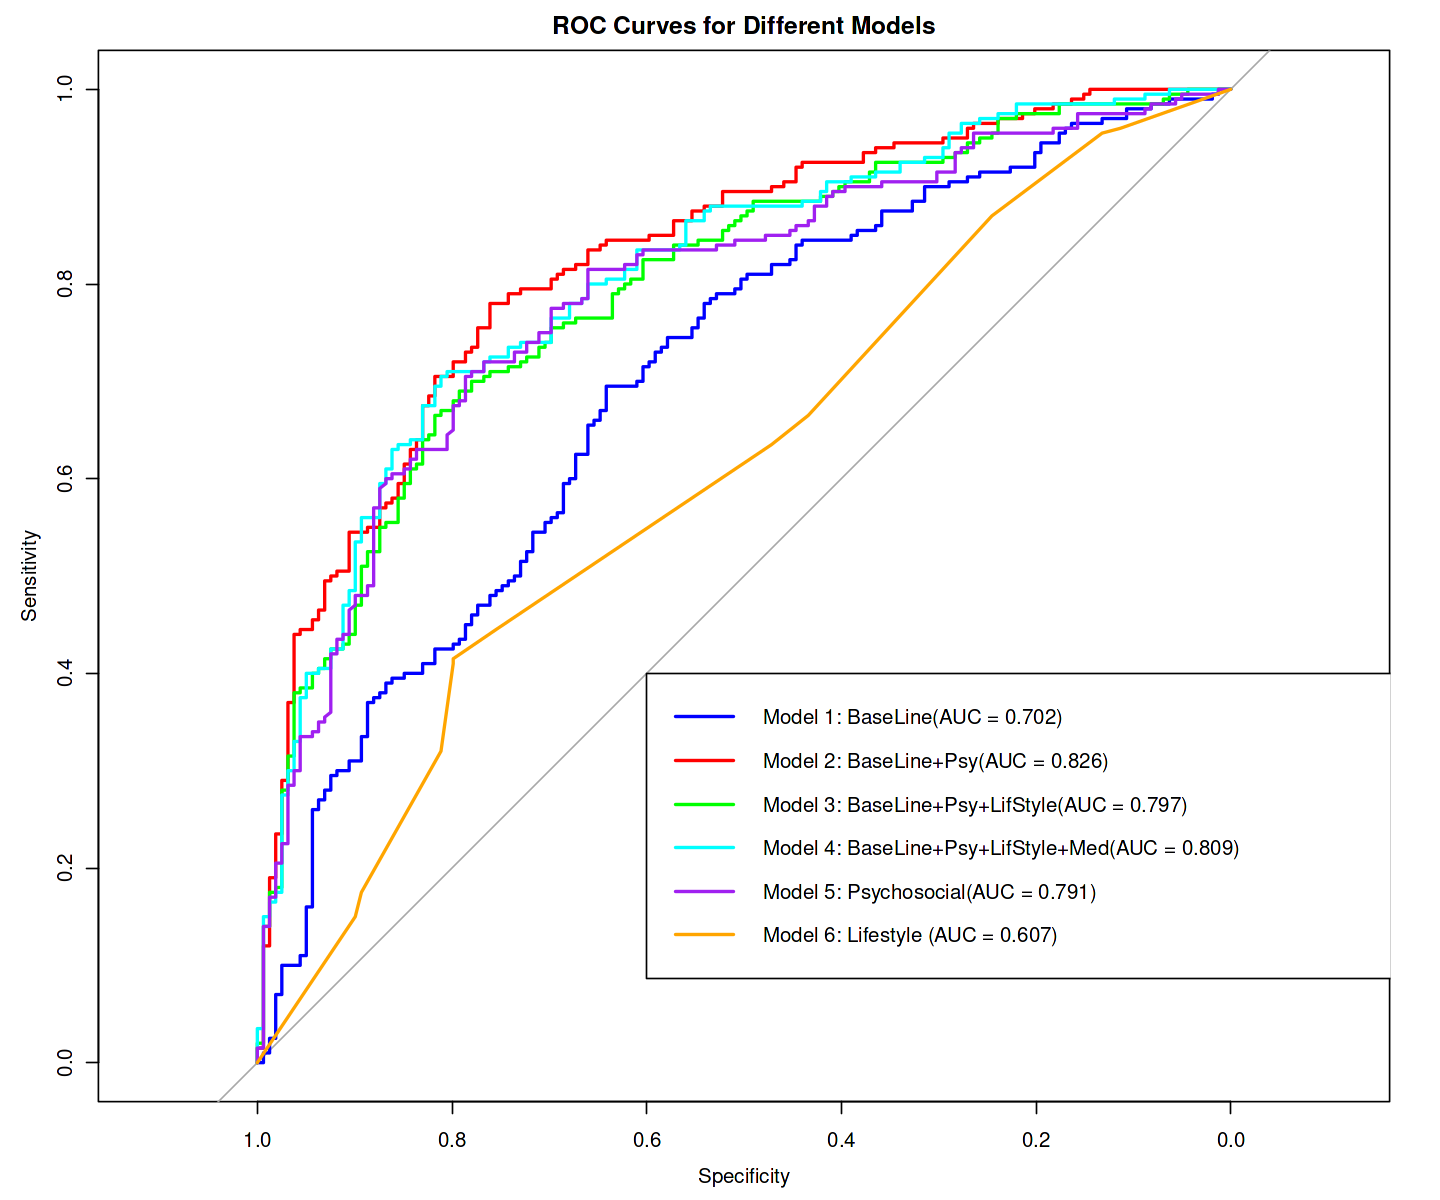

In [145]:
# Plot ROC Curves for All Models
roc_model1 <- metrics_model1$roc_curve
roc_model2 <- metrics_model2$roc_curve
roc_model3 <- metrics_model3$roc_curve
roc_model4 <- metrics_model4$roc_curve
roc_model5 <- metrics_model5$roc_curve
roc_model6 <- metrics_model6$roc_curve

# ROC plot
# Prepare legend labels with model names and AUC values
    legend_labels <- c(
        paste0("Model 1: BaseLine(AUC = ", sprintf("%.3f", auc(roc_model1)), ")"),
        paste0("Model 2: BaseLine+Psy(AUC = ", sprintf("%.3f", auc(roc_model2)), ")"),
        paste0("Model 3: BaseLine+Psy+LifStyle(AUC = ", sprintf("%.3f", auc(roc_model3)), ")"),
        paste0("Model 4: BaseLine+Psy+LifStyle+Med(AUC = ", sprintf("%.3f", auc(roc_model4)), ")"),
        paste0("Model 5: Psychosocial(AUC = ", sprintf("%.3f", auc(roc_model5)), ")"),
        paste0("Model 6: Lifestyle (AUC = ", sprintf("%.3f", auc(roc_model6)), ")")
    )
    # Create ROC plot
    plot(roc_model1, col = "blue", main = "ROC Curves for Different Models")
    plot(roc_model2, col = "red", add = TRUE)
    plot(roc_model3, col = "green", add = TRUE)
    plot(roc_model4, col = "cyan", add = TRUE)
    plot(roc_model5, col = "purple", add = TRUE)
    plot(roc_model6, col = "orange", add = TRUE)
    
    # Add legend
    legend(x = 0.6, y = 0.4, 
           legend = legend_labels,
           col = c("blue", "red", "green", "cyan", "purple", "orange"),
           lwd = 2)
    


In [146]:
# Create a results table
results_table <- data.frame(
    Model = c("Model 1: BaseLine", 
              "Model 2: BaseLine+Psychosocial", 
              "Model 3: BaseLine+P+Lifestyle", 
              "Model 4: BaseLine+P+Lifestyle+Med",               
              "Model 5: Psychosocial", 
              "Model 6: Lifestyle"),
    Sensitivity = c(metrics_model1$metrics[1], metrics_model2$metrics[1],
                    metrics_model3$metrics[1],metrics_model4$metrics[1],
                   metrics_model5$metrics[1], metrics_model6$metrics[1]),
    
    Specificity = c(metrics_model1$metrics[2], metrics_model2$metrics[2],
                    metrics_model3$metrics[2], metrics_model4$metrics[2],
                    metrics_model5$metrics[2], metrics_model6$metrics[2]),
    
    PPV = c(metrics_model1$metrics[3], metrics_model2$metrics[3],
            metrics_model3$metrics[3], metrics_model4$metrics[3],
           metrics_model5$metrics[3], metrics_model6$metrics[3]),
    
    NPV = c(metrics_model1$metrics[4], metrics_model2$metrics[4],
            metrics_model3$metrics[4],metrics_model4$metrics[4],
            metrics_model5$metrics[4], metrics_model6$metrics[4])
)

# Print the results table
print(results_table)

                              Model Sensitivity Specificity       PPV       NPV
1                 Model 1: BaseLine       0.695   0.6415094 0.7091837 0.6257669
2    Model 2: BaseLine+Psychosocial       0.780   0.7610063 0.8041237 0.7333333
3     Model 3: BaseLine+P+Lifestyle       0.665   0.8176101 0.8209877 0.6598985
4 Model 4: BaseLine+P+Lifestyle+Med       0.705   0.8113208 0.8245614 0.6861702
5             Model 5: Psychosocial       0.705   0.7861635 0.8057143 0.6793478
6                Model 6: Lifestyle       0.415   0.7987421 0.7217391 0.5204918


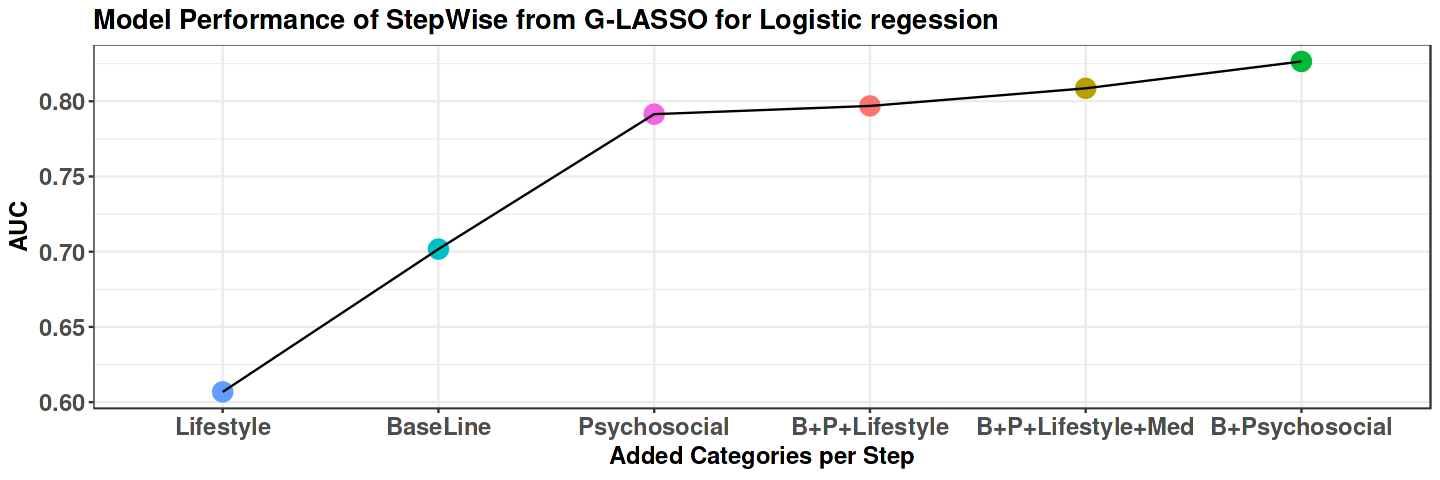

In [147]:
# data frame for models importance
variable_importance <- data.frame(
  Variable = c("BaseLine", "B+Psychosocial", "B+P+Lifestyle", 
               "B+P+Lifestyle+Med",
               "Psychosocial", "Lifestyle"),
  Importance = c(metrics_model1$auc, metrics_model2$auc, 
                 metrics_model3$auc, metrics_model4$auc,
                metrics_model5$auc, metrics_model6$auc)
)
options(repr.plot.width=12, repr.plot.height=4)
# Create Figure : Variable Importance Plot
ggplot(variable_importance, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_point(aes(color = Variable), size = 5) +
  geom_line(group = 12) +
  labs(title = "Model Performance of StepWise from G-LASSO for Logistic regession",
       x = "Added Categories per Step",
       y = "AUC")+
  theme_bw() + # Apply a clean theme
  theme(
      legend.position="none",
    plot.title = element_text(size = 16, face = "bold"), # Title size and style
    axis.title.x = element_text(size = 14, face = "bold"), # X-axis label size
    axis.title.y = element_text(size = 14, face = "bold"), # Y-axis label size
    axis.text.x = element_text(size = 14, face = "bold"), # X-axis text size
    axis.text.y = element_text(size = 14, face = "bold") # Y-axis text size
  ) 


In [ ]:
plot(model1)
plot(model2)
plot(model3)
plot(model4)
 plot(model5)
plot(model6)